In [ ]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # pr'int content of ROOT (Optional)

drive.mount(ROOT)

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**SETTING UP DIRECTORIES**

In [ ]:
MY_GOOGLE_DRIVE_PATH = 'My Drive/ADL_12162020/'
GIT_TOKEN = '418ef650c19648943e83f603b347b5da5012edc8'
GIT_USERNAME = 'AmoghM'
GIT_REPOSITORY = 'Hate-Toxicity-Detection'

from os.path import join  

PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

In [ ]:
%cd "{PROJECT_PATH}"
%cd "Hate-Toxicity-Detection"

/content/drive/My Drive/ADL_12162020
/content/drive/My Drive/ADL_12162020/Hate-Toxicity-Detection


In [ ]:
!pip install transformers

**Imports**

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from collections import Counter
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader
import random
from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.pyplot import figure
mport warnings
warnings.filterwarnings('ignore')


**Getting Dataset**

In [ ]:
def get_dataset(mode = 'train', model_type = 'bert', class_map = None, max_inp_len = 100, file_path = None, task_type = None, batch_size = 8):
  """ Reads the csv file from data dir and returns a Tensor DataSet """
  data = pd.read_csv(file_path, sep="\t")

  if task_type == 'task_1':
    labels = list(class_map.keys())
    data = data[data['task_1'].isin(labels)]
    data['label'] = data.apply(lambda row: class_map[row['task_1']], axis=1)
  
  if task_type == 'task_2':
    labels = list(class_map.keys())
    data = data[data['task_2'].isin(labels)]
    data['label'] = data.apply(lambda row: class_map[row['task_2']], axis=1)
  
  if task_type == 'task_3':
      labels = list(class_map.keys())
      data = data[data['task_3'].isin(labels)]
      data['label'] = data.apply(lambda row: class_map[row['task_3']], axis=1)
  
  x = data['text'].values
  y = data['label'].values

  tokenizer = AutoTokenizer.from_pretrained('model_artifacts/' + model_type + '', do_lower_case = True)
  input_ids = [tokenizer.encode(i, add_special_tokens = True) for i in x]
  input_ids = pad_sequences(input_ids, maxlen=max_inp_len, dtype="long", value=0, truncating="post", padding="post")
  labels = y

  attention_masks = [[int(token_id > 0) for token_id in x] for x in input_ids]
  
  if mode == "train":
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.25)
    train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.25)

    train_inputs = torch.tensor(train_inputs)
    validation_inputs = torch.tensor(validation_inputs)
    train_labels = torch.tensor(train_labels)
    validation_labels = torch.tensor(validation_labels)
    train_masks = torch.tensor(train_masks)
    validation_masks = torch.tensor(validation_masks)
    
    train_set = TensorDataset(train_inputs, train_masks, train_labels)
    validation_set = TensorDataset(validation_inputs, validation_masks, validation_labels)
    return train_set, validation_set
  else:
    test_inputs = torch.tensor(input_ids)
    test_masks = torch.tensor(attention_masks)
    test_labels = torch.tensor(labels)
    
    test_set = TensorDataset(test_inputs, test_masks, test_labels)
    return test_set


**Get GPU Device**

In [ ]:
def get_device():
  if torch.cuda.is_available():    
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")
  return device

**Set Random Seed**

In [ ]:
def set_random_seed(seed_val = 42):
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)


**Get Transformer Model**

In [ ]:
def get_model(model_type = 'bert', num_classes = 2):
  """ takes transformer model type as input and returns pytorch model with Hugging Face checkpoint """
  model = BertForSequenceClassification.from_pretrained('model_artifacts/' + model_type + '/', num_labels = num_classes, \
                                                        output_attentions = False, output_hidden_states = False)
  try:
    model.cuda()
  except Exception as e:
    print('GPU not found! running on CPU mode')
  return model 

**Get optimizer**

In [ ]:
def get_optimizer(model, learning_rate = 5e-5, warmup_steps = 100, num_epochs = 4, total_steps = 100):
  """ takes model and optimizer params as input and returns optimizer and scheduler """
  optimizer = AdamW(model.parameters(), lr = learning_rate, eps = 1e-8)
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps,
                                          num_training_steps = total_steps)
  return (optimizer, scheduler)

**Get Accuracy Metrics**

In [ ]:
import numpy as np
# Function to calculate the accuracy of our predictions vs labels
def get_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def update_conf_matrix(preds, labels, preds_arr, labels_arr):
  """ receives actual and predicted labels of a minibatch and returns the updated confusion matrix """
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  preds_arr = np.concatenate((preds_arr, pred_flat), axis = 0)
  labels_arr = np.concatenate((labels_arr, labels_flat), axis = 0)

  return (preds_arr, labels_arr)
  
def display_classification_report(y_pred, y_true, class_map):
  target_arr=[None] * len(class_map)
  for key in class_map.keys():
    target_arr[class_map[key]] = key

  print(classification_report(y_true, y_pred, target_names = target_arr))

def generate_loss_plot(x_val, y_vals):
  plt.figure(figsize=(10,10))

  for y_val in y_vals:
    plt.plot(x_val, y_val)
  plt.legend(['Validation loss','Training loss'])
  plt.xlabel("Num of Epochs")
  plt.ylabel("Loss function ")
  plt.title("Training and Validation Loss")
  plt.show()



**Validation Function**

In [ ]:
def validate(model, validation_dataloader = None, num_classes  = 2, class_map = {}):
    print("Running Validation...")
    device = get_device()
    num_classes = len(list(class_map.keys()))
    conf_mat = torch.zeros(num_classes, num_classes)
    preds_arr = np.array([])
    labels_arr = np.array([])

    model.eval()
    eval_loss, eval_accuracy = 0, 0
    eval_steps, eval_examples = 0, 0
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)    
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_accuracy = get_accuracy(logits, label_ids)
        preds_arr, labels_arr = update_conf_matrix(logits, label_ids, preds_arr, labels_arr)

        
        eval_accuracy += tmp_eval_accuracy
        eval_loss += loss.item()
        eval_steps += 1
    print("  Accuracy: {0:.2f}".format(eval_accuracy/eval_steps))
    display_classification_report(preds_arr, labels_arr, class_map)
    eval_accuracy /= eval_steps
    eval_loss /= eval_steps
    return (eval_accuracy, eval_loss)


**Train Function**

In [ ]:
def train(model = None, train_set = None, val_set = None, test_set = None, train_params = None, class_map = {}):
  num_classes = len(list(class_map.keys()))
  train_dataloader = DataLoader(train_set, batch_size = train_params['batch_size'], shuffle = True)
  val_dataloader = DataLoader(val_set, batch_size = train_params['batch_size'], shuffle = True)
  device = get_device()

  if test_set is not None:
    test_dataloader = DataLoader(test_set, batch_size = train_params['batch_size'], shuffle = True)
  
  total_steps = len(train_dataloader) * train_params['num_epochs']
  optimizer, scheduler = get_optimizer(model, learning_rate = train_params['learning_rate'], warmup_steps = train_params['warmup_steps'], \
                                       num_epochs = train_params['num_epochs'], total_steps = total_steps)
  
  curr_step = 0
  loss_values = []
  val_loss_values = []
  for epoch_i in range(0, train_params['num_epochs']):
    
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 100 == 0 and not step == 0:
          # print('Epoch = %d, step = %d'%(epoch_i, step))
          print(" For epoch = {0}, step = {1}, average training loss: {2:.3f}".format(epoch_i+1, step, total_loss/(step+1)))
          # val_accuracy, val_loss = validate(model, validation_dataloader = val_dataloader, num_classes= num_classes, class_map = class_map)
    

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        outputs = model(b_input_ids, token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)            
    
    loss_values.append(avg_train_loss)
    print("End of epoch  Average training loss: {0:.2f}".format(avg_train_loss))
    val_accuracy, val_loss = validate(model, validation_dataloader = val_dataloader, class_map = class_map)
    val_loss_values.append(val_loss)
    

  print("")
  print("Training complete!")
  generate_loss_plot(np.arange(train_params['num_epochs'])+1, [ val_loss_values, loss_values])

  print("Evaluating on test set")
  validate(model, validation_dataloader = test_dataloader, num_classes = num_classes, class_map = class_map)
  

  


# **MAIN**

**DEFINING CONFIG PARAMS**

In [ ]:
task_1_map = {'NOT' : 0, 'HOF' : 1}
task_2_map = {'HATE': 0, 'NONE': 1, 'OFFN': 2, 'PRFN': 3}
task_3_map = {'NONE': 0, 'TIN': 1, 'UNT': 2}

train_params = { 'batch_size' : 8, 'num_epochs' : 4, 'learning_rate' : 2e-5, 'warmup_steps' : 50, 'max_inp_len' : 100}

**FOR TASK 1: FETCHING DATASETS, RUNNING TRAIN AND VALIDATION**

Some weights of the model checkpoint at model_artifacts/bert/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoin

 For epoch = 1, step = 100, average training loss: 0.665
 For epoch = 1, step = 200, average training loss: 0.654
 For epoch = 1, step = 300, average training loss: 0.643
 For epoch = 1, step = 400, average training loss: 0.639
 For epoch = 1, step = 500, average training loss: 0.631
End of epoch  Average training loss: 0.63
Running Validation...
  Accuracy: 0.69
              precision    recall  f1-score   support

         NOT       0.70      0.87      0.77       903
         HOF       0.65      0.38      0.48       560

    accuracy                           0.69      1463
   macro avg       0.67      0.63      0.63      1463
weighted avg       0.68      0.69      0.66      1463

 For epoch = 2, step = 100, average training loss: 0.543
 For epoch = 2, step = 200, average training loss: 0.536
 For epoch = 2, step = 300, average training loss: 0.536
 For epoch = 2, step = 400, average training loss: 0.536
 For epoch = 2, step = 500, average training loss: 0.526
End of epoch  Average 

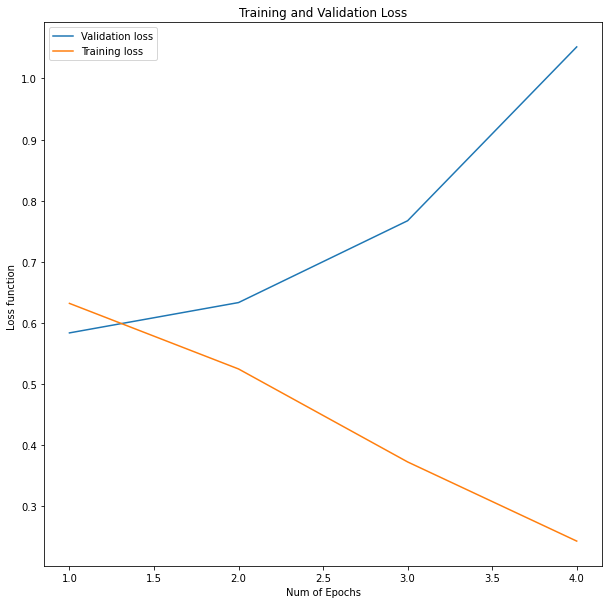

Evaluating on test set
Running Validation...
  Accuracy: 0.77
              precision    recall  f1-score   support

         NOT       0.91      0.77      0.84       865
         HOF       0.53      0.76      0.63       288

    accuracy                           0.77      1153
   macro avg       0.72      0.77      0.73      1153
weighted avg       0.81      0.77      0.78      1153



In [ ]:
class_map = task_1_map
task_type = 'task_1'
train_file_path = "data/english_dataset/english_dataset.tsv"
test_file_path = "data/english_dataset/hasoc2019_en_test-2919.tsv"


set_random_seed(seed_val = 42)

train_set, val_set = get_dataset(mode = 'train', model_type = 'bert', class_map = class_map, max_inp_len = train_params['max_inp_len'], \
                                 file_path = train_file_path, task_type = task_type, batch_size = train_params['batch_size'])

test_set = get_dataset(mode = 'test', model_type = 'bert', class_map = class_map, max_inp_len = train_params['max_inp_len'], \
                                 file_path = test_file_path, task_type = task_type, batch_size = train_params['batch_size'])

model = get_model(model_type = 'bert', num_classes = len(list(class_map.keys())))

train(model = model, train_set = train_set, val_set = val_set, test_set = test_set, train_params = train_params, class_map = class_map)

**FOR TASK 2: FETCHING DATASETS, RUNNING TRAIN AND VALIDATION**

Some weights of the model checkpoint at model_artifacts/bert/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoin

 For epoch = 1, step = 100, average training loss: 1.104
 For epoch = 1, step = 200, average training loss: 1.089
 For epoch = 1, step = 300, average training loss: 1.061
 For epoch = 1, step = 400, average training loss: 1.030
 For epoch = 1, step = 500, average training loss: 1.010
End of epoch  Average training loss: 1.00
Running Validation...
  Accuracy: 0.65
              precision    recall  f1-score   support

        HATE       0.00      0.00      0.00       286
        NONE       0.66      0.97      0.78       903
        OFFN       0.00      0.00      0.00       111
        PRFN       0.64      0.48      0.55       163

    accuracy                           0.65      1463
   macro avg       0.32      0.36      0.33      1463
weighted avg       0.48      0.65      0.54      1463



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 For epoch = 2, step = 100, average training loss: 0.823
 For epoch = 2, step = 200, average training loss: 0.859
 For epoch = 2, step = 300, average training loss: 0.864
 For epoch = 2, step = 400, average training loss: 0.851
 For epoch = 2, step = 500, average training loss: 0.843
End of epoch  Average training loss: 0.84
Running Validation...
  Accuracy: 0.65
              precision    recall  f1-score   support

        HATE       0.35      0.10      0.16       286
        NONE       0.70      0.91      0.79       903
        OFFN       0.33      0.17      0.22       111
        PRFN       0.58      0.51      0.54       163

    accuracy                           0.65      1463
   macro avg       0.49      0.42      0.43      1463
weighted avg       0.59      0.65      0.59      1463

 For epoch = 3, step = 100, average training loss: 0.710
 For epoch = 3, step = 200, average training loss: 0.702
 For epoch = 3, step = 300, average training loss: 0.711
 For epoch = 3, step = 400, 

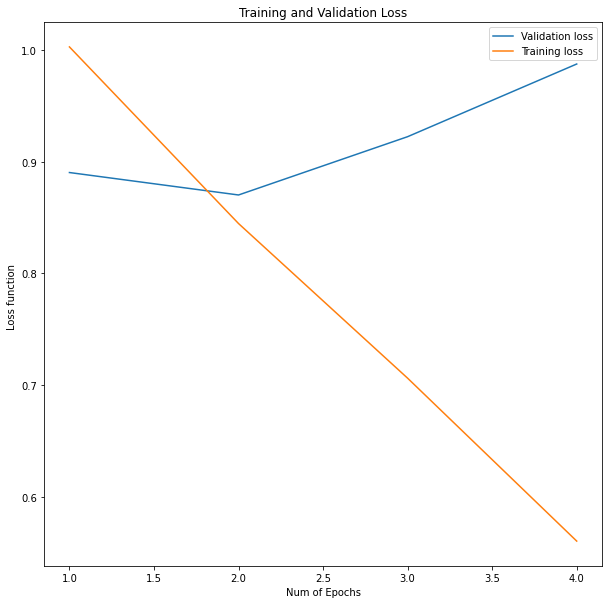

Evaluating on test set
Running Validation...
  Accuracy: 0.72
              precision    recall  f1-score   support

        HATE       0.27      0.61      0.37       124
        NONE       0.91      0.77      0.83       865
        OFFN       0.35      0.11      0.17        71
        PRFN       0.66      0.83      0.74        93

    accuracy                           0.71      1153
   macro avg       0.55      0.58      0.53      1153
weighted avg       0.79      0.71      0.73      1153



In [ ]:
class_map = task_2_map
task_type = 'task_2'
train_file_path = "data/english_dataset/english_dataset.tsv"
test_file_path = "data/english_dataset/hasoc2019_en_test-2919.tsv"


set_random_seed(seed_val = 42)

train_set, val_set = get_dataset(mode = 'train', model_type = 'bert', class_map = class_map, max_inp_len = train_params['max_inp_len'], \
                                 file_path = train_file_path, task_type = task_type, batch_size = train_params['batch_size'])

test_set = get_dataset(mode = 'test', model_type = 'bert', class_map = class_map, max_inp_len = train_params['max_inp_len'], \
                                 file_path = test_file_path, task_type = task_type, batch_size = train_params['batch_size'])

model = get_model(model_type = 'bert', num_classes = len(list(class_map.keys())))

train(model = model, train_set = train_set, val_set = val_set, test_set = test_set, train_params = train_params, class_map = class_map)

**FOR TASK 3: FETCHING DATASETS, RUNNING TRAIN AND VALIDATION**

Some weights of the model checkpoint at model_artifacts/bert/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoin

 For epoch = 1, step = 100, average training loss: 0.904
 For epoch = 1, step = 200, average training loss: 0.851
 For epoch = 1, step = 300, average training loss: 0.818
 For epoch = 1, step = 400, average training loss: 0.796
 For epoch = 1, step = 500, average training loss: 0.787
End of epoch  Average training loss: 0.78
Running Validation...
  Accuracy: 0.68
              precision    recall  f1-score   support

        NONE       0.69      0.94      0.79       903
         TIN       0.67      0.31      0.42       503
         UNT       0.00      0.00      0.00        57

    accuracy                           0.68      1463
   macro avg       0.45      0.42      0.41      1463
weighted avg       0.65      0.68      0.63      1463



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 For epoch = 2, step = 100, average training loss: 0.660
 For epoch = 2, step = 200, average training loss: 0.650
 For epoch = 2, step = 300, average training loss: 0.640
 For epoch = 2, step = 400, average training loss: 0.642
 For epoch = 2, step = 500, average training loss: 0.647
End of epoch  Average training loss: 0.65
Running Validation...
  Accuracy: 0.68
              precision    recall  f1-score   support

        NONE       0.72      0.84      0.78       903
         TIN       0.61      0.47      0.53       503
         UNT       0.12      0.04      0.05        57

    accuracy                           0.68      1463
   macro avg       0.48      0.45      0.45      1463
weighted avg       0.66      0.68      0.66      1463

 For epoch = 3, step = 100, average training loss: 0.536
 For epoch = 3, step = 200, average training loss: 0.501
 For epoch = 3, step = 300, average training loss: 0.511
 For epoch = 3, step = 400, average training loss: 0.504
 For epoch = 3, step = 50

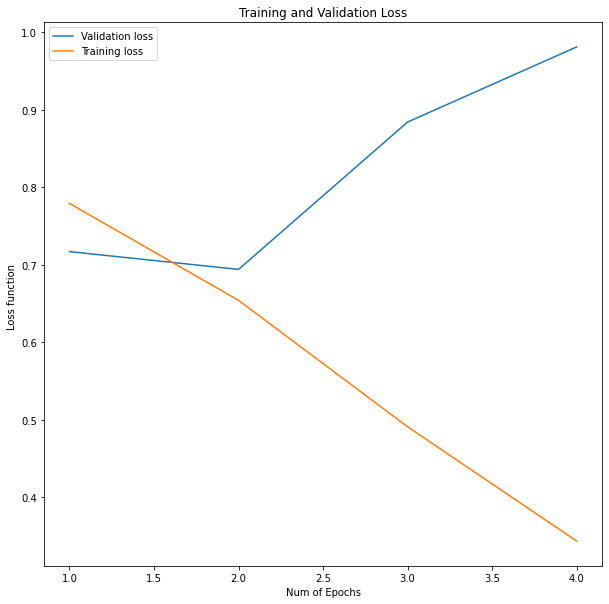

Evaluating on test set
Running Validation...
  Accuracy: 0.74
              precision    recall  f1-score   support

        NONE       0.90      0.80      0.85       865
         TIN       0.48      0.65      0.55       245
         UNT       0.04      0.05      0.04        43

    accuracy                           0.74      1153
   macro avg       0.47      0.50      0.48      1153
weighted avg       0.78      0.74      0.75      1153



In [ ]:
class_map = task_3_map
task_type = 'task_3'
train_file_path = "data/english_dataset/english_dataset.tsv"
test_file_path = "data/english_dataset/hasoc2019_en_test-2919.tsv"


set_random_seed(seed_val = 42)

train_set, val_set = get_dataset(mode = 'train', model_type = 'bert', class_map = class_map, max_inp_len = train_params['max_inp_len'], \
                                 file_path = train_file_path, task_type = task_type, batch_size = train_params['batch_size'])

test_set = get_dataset(mode = 'test', model_type = 'bert', class_map = class_map, max_inp_len = train_params['max_inp_len'], \
                                 file_path = test_file_path, task_type = task_type, batch_size = train_params['batch_size'])

model = get_model(model_type = 'bert', num_classes = len(list(class_map.keys())))

train(model = model, train_set = train_set, val_set = val_set, test_set = test_set, train_params = train_params, class_map = class_map)